# Слои нелинейной активации (Non Linear Activations)_Вариант №12


Слои нелинейной активации (Non Linear Activations) - это специальные слои в нейронных сетях, которые используются для добавления нелинейности к модели. Они применяются к выходу каждого слоя для того, чтобы добавить нелинейность и повысить возможности модели для обработки сложных задач.<br>
Существует множество различных функций активации, но некоторые из самых популярных:<br>
ReLU (Rectified Linear Unit): эта функция активации возвращает значение входного значения, если оно больше 0, и 0 в противном случае. ReLU широко используется в сверточных нейронных сетях, так как она позволяет ускорить процесс обучения и улучшить качество модели.
Sigmoid: эта функция активации имеет S-образную форму и используется для преобразования линейных значений в вероятности в диапазоне от 0 до 1. Она часто используется в задачах классификации.<br>
Tanh (Hyperbolic tangent): эта функция активации имеет гиперболический тангенс в качестве формы и используется для преобразования линейных значений в диапазон от -1 до 1. Она часто используется в рекуррентных нейронных сетях.
Softmax: эта функция активации используется для преобразования линейных значений в вероятностный вектор в диапазоне от 0 до 1. <br>
Она часто используется в задачах классификации для определения вероятности каждого  класса.<br>
Важно отметить, что выбор функции активации может иметь значительное влияние на качество и скорость обучения модели. В зависимости от типа задачи и данных, одна или несколько функций активации могут быть более подходящими для использования. Часто используются сочетания различных функций активации для решения сложных задач.

**class** torch.nn.ReLU(inplace=False)<br>
Применяет выпрямленную линейную единичную функцию поэлементно:<br>
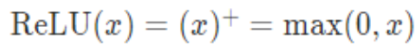
<br>**Parameters**<br>
inplace — при желании можно выполнить операцию на месте. По умолчанию: False<br>
Shape:<br>
Input:(N, *) где * означает любое количество дополнительных измерений.<br>Output:(N, *) , та же форма, что и вход.


**Пример**

In [ ]:
m = nn.ReLU()
input = torch.randn(2)
output = m(input)
m = nn.ReLU()
input = torch.randn(2).unsqueeze(0)
output = torch.cat((m(input),m(-input)))

class torch.nn.Sigmoid<br>
Применяет функцию "по элементам" :<br>
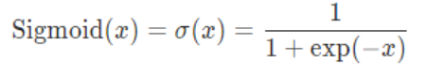
Shape:<br>
Input:(N, *) где * означает любое количество дополнительных измерений
<br>Output:(N, *) , та же форма, что и вход



In [ ]:
m = nn.Sigmoid()
input = torch.randn(2)
output = m(input)

class torch.nn.Tanh
Применяет функцию "по элементам":<br>
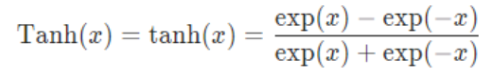<br>
Shape:<br>
Input:(N, *) где * означает любое количество дополнительных измерений
<br>Output:(N, *) , та же форма, что и вход


In [ ]:
m = nn.Tanh()
input = torch.randn(2)
output = m(input)

# Задача 2_Вариант №12

In [31]:
import re
import typing as t
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import wordnet, stopwords
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [32]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

In [34]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [35]:
CUDA = "cuda"
CPU = "cpu"
DEVICE = CUDA if torch.cuda.is_available() else CPU
print(f"Using {DEVICE.upper()} device")

Using CUDA device


In [36]:
def get_pos(word: str) -> str:
    tag = nltk.pos_tag([word])[0][1]
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


_wordnet_lemmatizer = nltk.WordNetLemmatizer()


def wordnet_lemmatizer(token: str) -> str:
    return _wordnet_lemmatizer.lemmatize(token, pos=get_pos(token))


_snowball_stemmer = nltk.SnowballStemmer(language="english")


def snowball_stemmer(token: str) -> str:
    return _snowball_stemmer.stem(token)


RE_NOT_ASCII_LOW = re.compile(r"[^a-z]", flags=re.MULTILINE)
RE_URL = re.compile(r"\w+://\S+", flags=re.MULTILINE)
STOPWORDS = set(stopwords.words("english"))


def preprocess_text(
        text: str,
        lemmatizer_or_stemmer: t.Callable[[str], str] = None,
        min_word_len: int = 0,
) -> str:
    text = text.lower()
    for pat in [RE_URL, RE_NOT_ASCII_LOW]:
        text = pat.sub(" ", text)

    words = []
    for word in nltk.word_tokenize(text):
        if word not in STOPWORDS and len(word) >= min_word_len:
            if not lemmatizer_or_stemmer:
                words.append(word)
                continue
            word = lemmatizer_or_stemmer(word)
            if word not in STOPWORDS and len(word) >= min_word_len:
                words.append(word)

    return " ".join(words)


class WordVocab:
    pad = "<PAD>"
    unknown = "<UNK>"

    def __init__(self, texts: t.List[str]):
        uniques = set()
        max_len = 0
        for text in texts:
            words = nltk.word_tokenize(text)
            uniques.update(words)
            max_len = max(len(words), max_len)

        self.alphabet = [self.pad, self.unknown, *uniques]
        self.max_len = max_len

        w2i = {w: i for i, w in enumerate(self.alphabet)}
        unknown_idx = w2i[self.unknown]
        self.w2i = defaultdict(lambda: unknown_idx, w2i)

    def __len__(self):
        return len(self.alphabet)

    def encode(self, text: str) -> torch.Tensor:
        indices = [self.w2i[w] for w in nltk.word_tokenize(text)]
        indices += [self.w2i[self.pad]] * (self.max_len - len(indices))
        return torch.tensor(indices, dtype=torch.long)

    def decode(self, indices: torch.Tensor) -> str:
        pad_indices = torch.nonzero(indices == self.w2i[self.pad], as_tuple=True)[0]  # noqa
        if len(pad_indices):
            indices = indices[:pad_indices[0]]
        return " ".join(self.alphabet[i] for i in indices)

In [37]:
class CoronaDataset(Dataset):
    DATA_COL = "OriginalTweet"
    TARGET_COL = "Sentiment"

    raw_texts: t.List[str]
    texts: t.List[str]

    encoder: LabelEncoder
    classes: t.List[str]

    vocab: WordVocab
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, vocab: WordVocab = None, encoder: LabelEncoder = None):
        self.raw_texts = df[self.DATA_COL].tolist()
        with tqdm(total=len(df)) as pbar:
            self._pbar, self._i, self._n = pbar, 0, 100
            self.texts = [self.preprocess_text(text) for text in self.raw_texts]
        self.vocab = vocab or WordVocab(self.texts)

        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = LabelEncoder()
            encode = self.encoder.fit_transform

        self.data = torch.vstack([self.vocab.encode(text) for text in self.texts])
        targets = encode(df[self.TARGET_COL])
        self.classes = self.encoder.classes_.tolist()
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def preprocess_text(self, text: str) -> str:
        self._i += 1
        if self._i % self._n == 0:
            self._pbar.update(self._n)
        return preprocess_text(text, lemmatizer_or_stemmer=snowball_stemmer, min_word_len=3)

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Positive              2783
Negative              2427
Neutral               1864
Extremely Positive    1589
Extremely Negative    1337
Name: Sentiment, dtype: int64


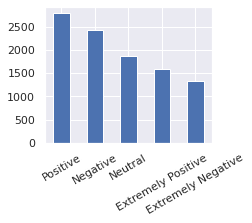

In [39]:
corona_df = pd.read_csv("drive/MyDrive/Colab Notebooks/EXAM_ML2023/corona.csv")
vc = corona_df["Sentiment"].value_counts()
print(vc)
corona_df["Sentiment"].value_counts().plot.bar(rot=30, figsize=(3, 2.5));

In [40]:
train_df, test_df = train_test_split(corona_df, test_size=0.2, random_state=0)

train_dataset = CoronaDataset(train_df)
test_dataset = CoronaDataset(
    test_df,
    vocab=train_dataset.vocab,
    encoder=train_dataset.encoder,
)
print(len(train_dataset.vocab), train_dataset.vocab.max_len)
len(train_dataset), len(test_dataset), train_dataset.classes

100%|██████████| 2000/2000 [00:00<00:00, 2457.75it/s]


14988 37


(8000,
 2000,
 ['Extremely Negative',
  'Extremely Positive',
  'Negative',
  'Neutral',
  'Positive'])

**Построение и обучение модели**

In [41]:
def get_weights(targets: torch.Tensor) -> torch.Tensor:
    _, counts = targets.unique(return_counts=True)
    return counts.max() / counts


def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        epochs: int,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[t.List[float], t.List[float], t.List[float], t.List[float]]:
    train_losses, train_accuracy_list = [], []
    test_losses, test_accuracy_list = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)

        train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer, verbose, device)
        print(f"Train Error: loss: {train_loss:.6f}, accuracy: {train_accuracy:.4f}")
        train_losses.append(train_loss)
        train_accuracy_list.append(train_accuracy)

        test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)
        print(f" Test Error: loss: {test_loss:.6f}, accuracy: {test_accuracy:.4f}\n")
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        torch.cuda.empty_cache()
    return train_losses, train_accuracy_list, test_losses, test_accuracy_list


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, avg_accuracy = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_true = torch.flatten(y).detach().cpu()
        y_pred = torch.flatten(pred.argmax(1)).detach().cpu()
        accuracy = metrics.accuracy_score(y_true, y_pred)

        avg_loss += loss
        avg_accuracy += accuracy
        if verbose and batch % verbose == 0:
            print(f"[{batch * len(x):>4d}/{size:>4d}]: loss: {loss:.6f}, accuracy: {accuracy:.4f}")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return (avg_loss / num_batches).item(), avg_accuracy / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader, device)
    return loss_fn(y_pred, y_true).item(), metrics.accuracy_score(y_true.cpu(), y_pred.argmax(1).cpu())


@torch.no_grad()
def get_y_true_y_pred(
        model: nn.Module,
        dataloader: DataLoader,
        device: str = CPU,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.flatten(torch.vstack(y_test)), torch.vstack(y_pred)


def plot_train_test(
        train_losses: t.List[float],
        train_accuracy: t.List[float],
        test_losses: t.List[float],
        test_accuracy: t.List[float],
) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(6, 7))
    epochs = torch.arange(len(train_losses))

    axes[0].plot(epochs, train_losses)
    axes[0].plot(epochs, test_losses)
    axes[0].set_ylabel("loss")
    axes[0].legend(["train", "test"])

    axes[1].plot(epochs, train_accuracy)
    axes[1].plot(epochs, test_accuracy)
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("accuracy")

In [42]:
class CoronaRNNClassifier(nn.Module):
    _STATE_T = t.Union[t.Optional[torch.Tensor], t.Optional[t.Tuple[torch.Tensor, torch.Tensor]]]
    rnn_state: _STATE_T

    def __init__(
            self,
            num_embeddings: int,
            embedding_dim: int,
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=0)
        self.rnn = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=rnn_hidden_size,
            num_layers=2,
            dropout=0.5,
            batch_first=True,
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.8),
            nn.Linear(rnn_hidden_size * vector_size, 2048),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(1024, num_classes),
        )
        self.reset_rnn_state()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)

        x, rnn_state = self.rnn(x, self.rnn_state)
        self.keep_rnn_state(rnn_state)

        x = torch.flatten(x, 1)
        return self.classifier(x)

    def reset_rnn_state(self):
        self.rnn_state = None

    def keep_rnn_state(self, state: _STATE_T):
        if isinstance(self.rnn, nn.LSTM):
            self.rnn_state = (state[0].detach(), state[1].detach())
        else:
            self.rnn_state = state.detach()

    def train(self, mode: bool = True):
        self.reset_rnn_state()
        return super().train(mode)

In [43]:
torch.manual_seed(0)

net = CoronaRNNClassifier(
    num_embeddings=len(train_dataset.vocab),
    embedding_dim=256,
    rnn_hidden_size=128,
    vector_size=train_dataset.vocab.max_len,
    num_classes=len(train_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=get_weights(train_dataset.targets).to(DEVICE))
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, drop_last=True)

net

CoronaRNNClassifier(
  (embedding): Embedding(14988, 256, padding_idx=0)
  (rnn): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.5)
  (classifier): Sequential(
    (0): Dropout(p=0.8, inplace=False)
    (1): Linear(in_features=4736, out_features=2048, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.8, inplace=False)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.8, inplace=False)
    (7): Linear(in_features=1024, out_features=5, bias=True)
  )
)

In [44]:
%%time

train_losses, train_accuracy, test_losses, test_accuracy = common_train(
    epochs=10,
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=DEVICE,
)

Epoch 1
--------------------------------
Train Error: loss: 1.534280, accuracy: 0.2846
 Test Error: loss: 1.256854, accuracy: 0.4102

Epoch 2
--------------------------------
Train Error: loss: 1.239537, accuracy: 0.4348
 Test Error: loss: 1.157978, accuracy: 0.4609

Epoch 3
--------------------------------
Train Error: loss: 1.025511, accuracy: 0.5349
 Test Error: loss: 1.127322, accuracy: 0.4740

Epoch 4
--------------------------------
Train Error: loss: 0.854326, accuracy: 0.6168
 Test Error: loss: 1.197505, accuracy: 0.5007

Epoch 5
--------------------------------
Train Error: loss: 0.703999, accuracy: 0.6853
 Test Error: loss: 1.292268, accuracy: 0.4857

Epoch 6
--------------------------------
Train Error: loss: 0.600295, accuracy: 0.7431
 Test Error: loss: 1.387912, accuracy: 0.5436

Epoch 7
--------------------------------
Train Error: loss: 0.511834, accuracy: 0.7826
 Test Error: loss: 1.420286, accuracy: 0.5306

Epoch 8
--------------------------------
Train Error: loss: 0.

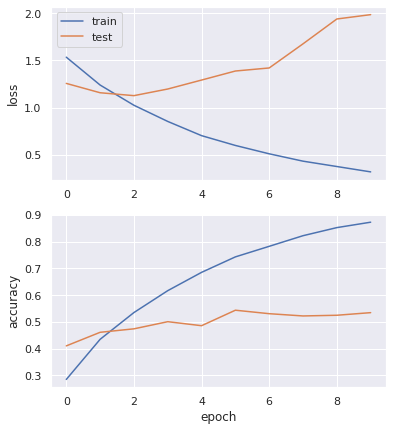

In [45]:
plot_train_test(train_losses, train_accuracy, test_losses, test_accuracy)

In [46]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader, DEVICE)
y_true, y_pred = y_true.cpu(), y_pred.argmax(1).cpu()

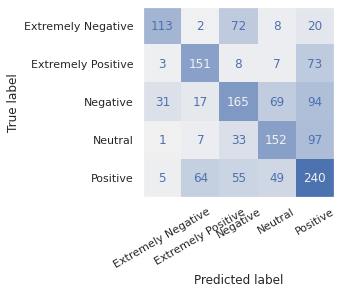

In [47]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=test_dataset.classes,
    colorbar=False,
    xticks_rotation=30,
    cmap=sns.color_palette('light:b', as_cmap=True)
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(3.5, 3.5)

In [48]:
print(metrics.classification_report(y_true, y_pred, target_names=test_dataset.classes, zero_division=True))

                    precision    recall  f1-score   support

Extremely Negative       0.74      0.53      0.61       215
Extremely Positive       0.63      0.62      0.63       242
          Negative       0.50      0.44      0.47       376
           Neutral       0.53      0.52      0.53       290
          Positive       0.46      0.58      0.51       413

          accuracy                           0.53      1536
         macro avg       0.57      0.54      0.55      1536
      weighted avg       0.55      0.53      0.54      1536



In [49]:
net.eval()
for i in torch.randperm(len(test_dataset))[:5]:
    x, y = test_dataset[i]
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = net(x.unsqueeze(0))

    pred_proba, pred_label_indices = torch.softmax(pred, 1).topk(min(len(test_dataset.classes), 3), dim=1)
    pred_labels = test_dataset.encoder.inverse_transform(pred_label_indices.squeeze().cpu())
    predicts = ", ".join([f"{label} ({prob:.2f})" for (label, prob) in zip(pred_labels, pred_proba.squeeze())])

    text = test_dataset.texts[i]
    text = text if len(text) < 80 else text[:80] + "..."
    target = test_dataset.encoder.inverse_transform([y.cpu()])[0]

    print(f"Input:   {text}")
    print(f"Target:  {target}")
    print(f"Predict: {predicts}\n")

Input:   hour sinc post peopl contact sale figur spectacular spike sale real take heart e...
Target:  Positive
Predict: Negative (0.53), Positive (0.27), Neutral (0.17)

Input:   ianbremm wish hurrican season approach live houston pretti worri covid low oil p...
Target:  Negative
Predict: Negative (0.58), Extremely Negative (0.25), Positive (0.15)

Input:   tns commit pay student worker administr laid food servic worker covid outbreak u...
Target:  Positive
Predict: Positive (0.58), Extremely Positive (0.40), Negative (0.02)

Input:   nytopinion surgic mask must avail everi supermarket unit state time done presid ...
Target:  Extremely Positive
Predict: Positive (0.84), Negative (0.07), Neutral (0.06)

Input:   cross run honest hard messag stayhom exercis socialdistanac still appli shop sup...
Target:  Negative
Predict: Negative (0.37), Positive (0.36), Neutral (0.10)



# Задача 3_Вариант №12

In [1]:
import typing as t
import random

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
from tqdm import tqdm

In [2]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [3]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (3.5, 2.5)

In [4]:
SignT = t.Literal[-1, 1]  # 1 - max, -1 - min
FuncT = t.Callable[[torch.Tensor], torch.Tensor]


def sign_func(func: FuncT, sign: SignT) -> FuncT:
    return lambda x: -sign * func(x)


def save_animation(xs: t.List[torch.Tensor], path: str, limit: int = 500, delay: int = 30) -> None:
    xs_ = xs.copy()
    delayed = xs_[-1]
    if len(xs_) > limit:
        xs_ = xs_[::len(xs_) // limit]
    for i in range(delay):
        xs_.append(delayed)

    with tqdm(total=len(xs_) + 1) as pbar:
        def animate(i):
            scatter.set_data(xs_[i].detach(), f(xs_[i]).detach())
            pbar.update()

        fig, ax = plt.subplots(1, 1)
        ax.plot(X.detach(), Y.detach())
        scatter, = ax.plot([], [], marker="o", color="r")
        anim = animation.FuncAnimation(fig, animate, interval=1, frames=len(xs_))
        anim.save(path, writer="pillow", fps=20)
        plt.close()


def answer(x: torch.Tensor, sign: SignT, reason: str) -> None:
    extrema = "минимум" if sign == -1 else "максимум"
    if torch.isnan(x):
        print(f"Локальный {extrema} не найден")
    else:
        x, y = x.item(), f(x).item()
        print(f"Найден локальный {extrema}: {x=:5f}, f(x)={y:5f}")
        plt.plot(X.detach(), Y.detach())
        plt.scatter(x, y, color="r")
    print(f"Причина остановки: {reason}")


def gradient_descent(
        func: FuncT,
        interval: t.Tuple[float, float],
        sign: SignT,
        eps: float,
        lr: float,
        initial_state: float = None,
) -> t.Tuple[torch.Tensor, t.List[torch.Tensor], str]:
    """Градиентный спуск"""
    sign_f = sign_func(func, sign)
    start, end = interval
    if initial_state is None:
        initial_state = random.uniform(start, end)
    elif initial_state < start or initial_state > end:
        return torch.tensor(torch.nan), [torch.tensor(torch.nan)], "initial_state вне интервала"

    interval_eps = lr * (end - start)  # наивное расширение границ интервала
    adj_start, adj_end = start - interval_eps, end + interval_eps

    x = torch.tensor(initial_state, dtype=torch.float, requires_grad=True)
    if torch.isnan(sign_f(x)):
        return torch.tensor(torch.nan), [torch.tensor(torch.nan)], f"f(initial_state={initial_state:.4f}) не определена"

    i, n = 0, 1000
    with tqdm() as pbar:
        xs = []
        while True:
            xs.append(x.detach().clone())  # выполнится минимум 2 раза

            if x < adj_start or x > adj_end:  # вышли за границу дальше дозволенного
                # искомый экстремум - предыдущая позиция или одна из границ
                start_t, end_t = torch.tensor(start), torch.tensor(end)
                if start <= xs[-2] <= end:
                    _, x = min((sign_f(xs[-2]), xs[-2]), (sign_f(start_t), start_t), (sign_f(end_t), end_t))
                else:
                    _, x = min((sign_f(start_t), start_t), (sign_f(end_t), end_t))
                xs.append(x.detach().clone())
                return xs[-1], xs, "выход за границы интервала"

            y = sign_f(x)
            if torch.isnan(y):
                xs.pop()
                return xs[-1], xs, f"функция для следующего x={x.item():.4f} не определена"

            # а эти 3 строчки про "возможности по автоматическому дифференцированию, которые предоставляет PyTorch"
            y.backward()
            grad = x.grad.clone()
            x.grad.zero_()

            with torch.no_grad():
                x -= lr * grad  # ладно, это 4-ая
                if torch.abs(x - xs[-1]) <= eps:  # найден экстремум с необходимой точностью
                    xs.append(x.detach().clone())
                    return xs[-1], xs, "найден экстремум"

            if i % n == 0:
                pbar.update(n)
            i += 1

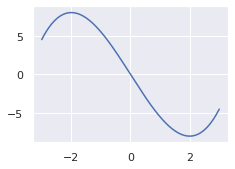

In [23]:
def f(x: torch.Tensor) -> torch.Tensor:
    return 0.5 * (x ** 3) - (6*x)


SIGN = -1  # 1 - max, -1 - min

START, END = -3, 3
EPS = 0.000001
LR = 0.001

X = torch.arange(START, END + 0.001, 0.001)
Y = f(X)
plt.plot(X.detach(), Y.detach());

2000it [00:00, 4771.70it/s]


Найден локальный минимум: x=1.999833, f(x)=-8.000000
Причина остановки: найден экстремум


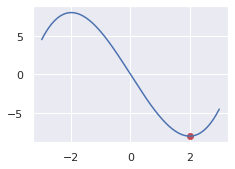

In [24]:
x, xs, reason = gradient_descent(func=f, interval=(START, END), sign=SIGN, eps=EPS, lr=LR, initial_state=0)
answer(x, SIGN, reason)

In [25]:
save_animation(xs, "optimization_3_1.gif")


100%|██████████| 590/590 [00:39<00:00, 14.76it/s]


2000it [00:00, 7376.91it/s] 


Найден локальный минимум: x=1.999833, f(x)=-8.000000
Причина остановки: найден экстремум


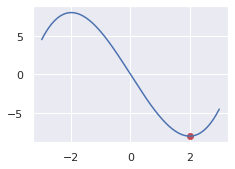

In [28]:
x, xs, reason = gradient_descent(func=f, interval=(START, END), sign=SIGN, eps=EPS, lr=LR, initial_state=0)
answer(x, SIGN, reason)

In [29]:
save_animation(xs, "optimization_3_2.gif")


100%|██████████| 590/590 [00:36<00:00, 16.08it/s]
